In [1]:
from algorithms.iterative_relaxation import IterativeRelaxation
from algorithms.decision_procedure import MarabouCoreDP
from algorithms.decision_tree import DecisionTree
from models.test_models import ProphecyPaperNetwork, TestModel

import torch
from torch import nn
import numpy as np
import pandas as pd  

Instructions for updating:
non-resource variables are not supported in the long term


### Labeled dataset for Prophecy paper's model

In [2]:
# we'll consider a range of -50 to 50 for our inputs x1 and x2. 
# We'll iterate through all possible pairs of (x1, x2) within this range, with increments of 1
model = ProphecyPaperNetwork()
_act_handles, activation_signature = model.attach_relu_activation_hook()
_out_handles, layer_outputs = model.attach_layer_output_hook()


def satisfies_postcond(output: list, postcond: int):
  # if postcond is y1, then y1 must be greater than every other class. 
  postcond_var = output[postcond]
  result = True
  for index, val in enumerate(output):
    if index == postcond: continue
    result = result and (postcond_var > val)
  result = 1 if result == True else -1
  return result

def create_training_df(inputs, postcond: int):
  data = []
  for input_data in inputs:
    X = torch.tensor([input_data], dtype=torch.float)
    logits = model(X)
    prediction_prob = nn.Softmax(dim=1)(logits)
    y_pred = prediction_prob.argmax(1)
    output = layer_outputs["final_output"][0].tolist()
    
    data_point = { 
      "input": input_data, 
      "output": output, 
      "satisfies_postcon": satisfies_postcond(output, postcond) 
    }
    for name, layer_activation in activation_signature.items():
      data_point[name] = [1 if val == "ON" else 0 for val in layer_activation]
    data.append(data_point)
    
  return pd.DataFrame(data)

In [3]:
# create input pairs for model
inputs = []
for x1 in np.arange(-50, 51, 1):
  for x2 in np.arange(-50, 51, 1):
    inputs.append([x1, x2])

df = create_training_df(inputs, 0)
print(len(df))
df.head(10)

10201


,input,output,satisfies_postcon,linear_relu_stack.1,linear_relu_stack.3
0,"[-50, -50]","[0.0, 0.0]",-1,"[0, 0]","[0, 0]"
1,"[-50, -49]","[0.0, 0.0]",-1,"[0, 0]","[0, 0]"
2,"[-50, -48]","[0.0, 0.0]",-1,"[0, 0]","[0, 0]"
3,"[-50, -47]","[0.0, 0.0]",-1,"[0, 0]","[0, 0]"
4,"[-50, -46]","[0.0, 0.0]",-1,"[0, 0]","[0, 0]"
5,"[-50, -45]","[0.0, 0.0]",-1,"[0, 0]","[0, 0]"
6,"[-50, -44]","[0.0, 0.0]",-1,"[0, 0]","[0, 0]"
7,"[-50, -43]","[0.0, 0.0]",-1,"[0, 0]","[0, 0]"
8,"[-50, -42]","[0.0, 0.0]",-1,"[0, 0]","[0, 0]"
9,"[-50, -41]","[0.0, 0.0]",-1,"[0, 0]","[0, 0]"


### Decision tree learning to find potential layer properties

In [4]:
layer_name = "linear_relu_stack.1"
decision_tree = DecisionTree(df, X_col=layer_name, Y_col="satisfies_postcon")
leaves_with_activation_pattern = decision_tree.get_potential_layer_properties()
leaves_with_activation_pattern

[{'node_id': 3,
  'sat_postcond': True,
  'support': 2550,
  'activation_pattern': ['ON', 'OFF']}]

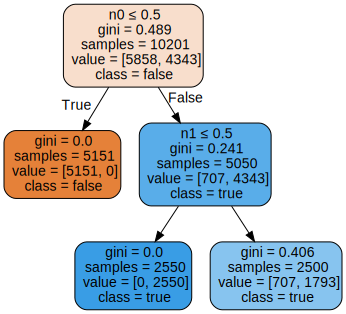

In [5]:
decision_tree.visualize_tree()

In [6]:
dp = MarabouCoreDP()
result = []
for leaf_data in leaves_with_activation_pattern:
  decision_pattern = { layer_name: leaf_data["activation_pattern"] }
  print(decision_pattern)
  status, _, _, _ = dp.solve(decision_pattern, model, 0)
  result.append({"decision_pattern": decision_pattern, "status": status})
result

{'linear_relu_stack.1': ['ON', 'OFF']}


[{'decision_pattern': {'linear_relu_stack.1': ['ON', 'OFF']},
  'status': 'unsat'}]

### Under-approximation box

In [7]:
from algorithms.under_approximation_box import UnderApproximationBox

box = UnderApproximationBox()
input_property = {'linear_relu_stack.1': ['ON', 'OFF']}
model = ProphecyPaperNetwork()

In [8]:
# get max and min of each input attributes from support
sat_postcon_df = df[df["satisfies_postcon"] == 1]
support_df = sat_postcon_df[sat_postcon_df['linear_relu_stack.1'].apply(lambda x: np.array_equal(x, [1, 0]))]
len(support_df)

2550

In [9]:
num_of_inputs = len(df.loc[0]["input"])

attr_max = []
attr_min = []
for i in range(num_of_inputs):
  attr_max.append(support_df['input'].apply(lambda x: x[i]).max())
  attr_min.append(support_df['input'].apply(lambda x: x[i]).min())

print(attr_min)  
print(attr_max)

[-49, -50]
[50, -1]


In [10]:
problem, result = box.solve(input_property, attr_min, attr_max, model)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/khoanguyen-cp/anaconda3/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/w_/0gmtp5d126l9hs74m0q5wgmr0000gq/T/a31b1f3e72c7419bb40618535e4a2a14-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/w_/0gmtp5d126l9hs74m0q5wgmr0000gq/T/a31b1f3e72c7419bb40618535e4a2a14-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 7 COLUMNS
At line 16 RHS
At line 19 BOUNDS
At line 28 ENDATA
Problem MODEL has 2 rows, 4 columns and 4 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-2) rows, 0 (-4) columns and 0 (-4) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 99
After Postsolve, objective 99, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 99 - 0 iterations time 0.002, Presolve 0.00
Option for printingOptions changed from n

In [11]:
for v in problem.variables():
  print(v.name, "=", v.varValue)

d_hi_0 = 50.0
d_hi_1 = -50.0
d_lo_0 = -49.0
d_lo_1 = -50.0
